In [ ]:
# Imports
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm.auto import tqdm  # Use auto to handle both notebook and terminal
import numpy as np
from datetime import datetime

# Local imports
from data.dataset import create_datasets, create_dataloaders
from models.cnn import create_custom_cnn
from utils.training import (
    calculate_class_weights,
    EarlyStopping,
    MetricsCalculator,
    TensorBoardLogger,
    save_checkpoint,
    load_checkpoint
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 3080 Laptop GPU


## 1. Configuration

In [7]:
# Configuration
class Config:
    # Paths
    DATA_DIR = project_root.parent / 'data' / 'processed'
    CHECKPOINT_DIR = project_root.parent / 'models_exported'
    LOG_DIR = project_root.parent / 'runs' / 'custom_cnn'
    
    # Model
    NUM_CLASSES = 38
    DROPOUT = 0.5
    MODEL_VARIANT = 'standard'  # 'standard' or 'small'
    
    # Training
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0.01
    
    # Scheduler
    T_0 = 5  # First restart period
    T_MULT = 2  # Period multiplier
    
    # Data
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    IMAGE_SIZE = 224
    
    # Training
    EARLY_STOPPING_PATIENCE = 7
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42

config = Config()

# Create directories
config.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
config.LOG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {config.DATA_DIR}")
print(f"Checkpoint directory: {config.CHECKPOINT_DIR}")
print(f"Device: {config.DEVICE}")

Data directory: d:\Repos\plant-disease-project\data\processed
Checkpoint directory: d:\Repos\plant-disease-project\models_exported
Device: cuda


In [8]:
# Set random seeds for reproducibility
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.SEED)
print(f"Random seed set to {config.SEED}")

Random seed set to 42


## 2. Load Data

In [9]:
# Create datasets first
from data.dataset import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(
    data_dir=config.DATA_DIR,
    image_size=config.IMAGE_SIZE
)

# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS
)

# Get class names from dataset
class_names = train_dataset.classes

print(f"Number of classes: {len(class_names)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Number of classes: 38
Training samples: 43429
Validation samples: 5417
Training batches: 1357
Validation batches: 170


In [10]:
# Calculate class weights for handling class imbalance
class_weights = calculate_class_weights(train_loader.dataset)
class_weights = class_weights.to(config.DEVICE)

print(f"Class weights shape: {class_weights.shape}")
print(f"Min weight: {class_weights.min():.4f}")
print(f"Max weight: {class_weights.max():.4f}")

Class weights shape: torch.Size([38])
Min weight: 0.2594
Max weight: 9.4452


## 3. Create Model

In [11]:
# Create model
model = create_custom_cnn(
    num_classes=config.NUM_CLASSES,
    variant=config.MODEL_VARIANT,
    dropout=config.DROPOUT
)
model = model.to(config.DEVICE)

print(f"Model created: Custom CNN ({config.MODEL_VARIANT})")
print(f"Total parameters: {model.get_num_params(trainable_only=False):,}")
print(f"Trainable parameters: {model.get_num_params(trainable_only=True):,}")

Model created: Custom CNN (standard)
Total parameters: 4,857,286
Trainable parameters: 4,857,286


## 4. Training Setup

In [12]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=config.T_0,
    T_mult=config.T_MULT
)

# Metrics calculator
metrics_calculator = MetricsCalculator(num_classes=config.NUM_CLASSES)

# TensorBoard logger
experiment_name = f"custom_cnn_{config.MODEL_VARIANT}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
logger = TensorBoardLogger(log_dir=config.LOG_DIR / experiment_name)

# Early stopping
early_stopping = EarlyStopping(
    patience=config.EARLY_STOPPING_PATIENCE,
    mode='max',
    min_delta=0.001
)

print(f"Experiment: {experiment_name}")
print(f"TensorBoard logs: {config.LOG_DIR / experiment_name}")

Experiment: custom_cnn_standard_20251204_235807
TensorBoard logs: d:\Repos\plant-disease-project\runs\custom_cnn\custom_cnn_standard_20251204_235807


In [13]:
# Training functions
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, logger=None):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    
    if logger:
        logger.log_scalar('train/loss', epoch_loss, epoch)
        logger.log_scalar('train/accuracy', epoch_acc, epoch)
        logger.log_scalar('train/lr', optimizer.param_groups[0]['lr'], epoch)
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device, epoch, metrics_calculator, logger=None):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    
    # Calculate metrics
    metrics = metrics_calculator.calculate(
        np.array(all_labels), 
        np.array(all_preds)
    )
    
    if logger:
        logger.log_scalar('val/loss', epoch_loss, epoch)
        logger.log_scalar('val/accuracy', metrics['accuracy'], epoch)
        logger.log_scalar('val/f1_macro', metrics['f1_macro'], epoch)
        logger.log_scalar('val/f1_weighted', metrics['f1_weighted'], epoch)
    
    return epoch_loss, metrics

print("Training functions defined.")

Training functions defined.


## 5. Training Loop

In [14]:
print("=" * 60)
print("TRAINING CUSTOM CNN")
print("=" * 60)

best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(1, config.EPOCHS + 1):
    print(f"\n--- Epoch {epoch}/{config.EPOCHS} ---")
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer,
        config.DEVICE, epoch, logger
    )
    
    # Validate
    val_loss, val_metrics = validate(
        model, val_loader, criterion, config.DEVICE,
        epoch, metrics_calculator, logger
    )
    
    # Step scheduler
    scheduler.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1_macro'])
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_macro']:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        save_checkpoint(
            model, optimizer, epoch, val_metrics['accuracy'],
            config.CHECKPOINT_DIR / 'custom_cnn_best.pth'
        )
        print(f"  -> New best model saved! (Acc: {best_val_acc:.4f})")
    
    # Early stopping check
    early_stopping(val_metrics['accuracy'])
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch}!")
        break

print(f"\nTraining Complete! Best Val Accuracy: {best_val_acc:.4f}")

TRAINING CUSTOM CNN

--- Epoch 1/50 ---


Epoch 1:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 3.3184, Train Acc: 0.1409
Val Loss: 2.1331, Val Acc: 0.3611, F1: 0.2700
LR: 0.000905
  -> New best model saved! (Acc: 0.3611)

--- Epoch 2/50 ---


Epoch 2:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 2.4463, Train Acc: 0.2974
Val Loss: 1.5859, Val Acc: 0.5064, F1: 0.4192
LR: 0.000655
  -> New best model saved! (Acc: 0.5064)

--- Epoch 3/50 ---


Epoch 3:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.9478, Train Acc: 0.4034
Val Loss: 1.3016, Val Acc: 0.5843, F1: 0.5106
LR: 0.000345
  -> New best model saved! (Acc: 0.5843)

--- Epoch 4/50 ---


Epoch 4:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.5478, Train Acc: 0.5154
Val Loss: 1.0237, Val Acc: 0.6478, F1: 0.5924
LR: 0.000095
  -> New best model saved! (Acc: 0.6478)

--- Epoch 5/50 ---


Epoch 5:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.3121, Train Acc: 0.5831
Val Loss: 0.8416, Val Acc: 0.7126, F1: 0.6695
LR: 0.001000
  -> New best model saved! (Acc: 0.7126)

--- Epoch 6/50 ---


Epoch 6:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.5426, Train Acc: 0.5190
Val Loss: 0.8174, Val Acc: 0.7410, F1: 0.6811
LR: 0.000976
  -> New best model saved! (Acc: 0.7410)

--- Epoch 7/50 ---


Epoch 7:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.2968, Train Acc: 0.5887
Val Loss: 0.8158, Val Acc: 0.7353, F1: 0.6941
LR: 0.000905
EarlyStopping: 1/7 epochs without improvement

--- Epoch 8/50 ---


Epoch 8:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 1.0782, Train Acc: 0.6618
Val Loss: 0.6525, Val Acc: 0.7711, F1: 0.7261
LR: 0.000794
  -> New best model saved! (Acc: 0.7711)

--- Epoch 9/50 ---


Epoch 9:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.8822, Train Acc: 0.7199
Val Loss: 0.7253, Val Acc: 0.7630, F1: 0.7313
LR: 0.000655
EarlyStopping: 1/7 epochs without improvement

--- Epoch 10/50 ---


Epoch 10:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.7467, Train Acc: 0.7594
Val Loss: 0.4656, Val Acc: 0.8453, F1: 0.8211
LR: 0.000500
  -> New best model saved! (Acc: 0.8453)

--- Epoch 11/50 ---


Epoch 11:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.5987, Train Acc: 0.8040
Val Loss: 0.3531, Val Acc: 0.8807, F1: 0.8504
LR: 0.000345
  -> New best model saved! (Acc: 0.8807)

--- Epoch 12/50 ---


Epoch 12:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.4962, Train Acc: 0.8382
Val Loss: 0.2245, Val Acc: 0.9286, F1: 0.9117
LR: 0.000206
  -> New best model saved! (Acc: 0.9286)

--- Epoch 13/50 ---


Epoch 13:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.4164, Train Acc: 0.8626
Val Loss: 0.1945, Val Acc: 0.9358, F1: 0.9123
LR: 0.000095
  -> New best model saved! (Acc: 0.9358)

--- Epoch 14/50 ---


Epoch 14:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3630, Train Acc: 0.8779
Val Loss: 0.1700, Val Acc: 0.9435, F1: 0.9237
LR: 0.000024
  -> New best model saved! (Acc: 0.9435)

--- Epoch 15/50 ---


Epoch 15:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3366, Train Acc: 0.8861
Val Loss: 0.1672, Val Acc: 0.9439, F1: 0.9245
LR: 0.001000
  -> New best model saved! (Acc: 0.9439)
EarlyStopping: 1/7 epochs without improvement

--- Epoch 16/50 ---


Epoch 16:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.6235, Train Acc: 0.7944
Val Loss: 0.6053, Val Acc: 0.7955, F1: 0.7846
LR: 0.000994
EarlyStopping: 2/7 epochs without improvement

--- Epoch 17/50 ---


Epoch 17:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.5379, Train Acc: 0.8277
Val Loss: 0.3176, Val Acc: 0.8948, F1: 0.8714
LR: 0.000976
EarlyStopping: 3/7 epochs without improvement

--- Epoch 18/50 ---


Epoch 18:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.4720, Train Acc: 0.8449
Val Loss: 0.3278, Val Acc: 0.8889, F1: 0.8684
LR: 0.000946
EarlyStopping: 4/7 epochs without improvement

--- Epoch 19/50 ---


Epoch 19:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.4505, Train Acc: 0.8554
Val Loss: 0.1990, Val Acc: 0.9323, F1: 0.9141
LR: 0.000905
EarlyStopping: 5/7 epochs without improvement

--- Epoch 20/50 ---


Epoch 20:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3760, Train Acc: 0.8757
Val Loss: 0.2313, Val Acc: 0.9225, F1: 0.9060
LR: 0.000854
EarlyStopping: 6/7 epochs without improvement

--- Epoch 21/50 ---


Epoch 21:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3471, Train Acc: 0.8858
Val Loss: 0.1330, Val Acc: 0.9570, F1: 0.9463
LR: 0.000794
  -> New best model saved! (Acc: 0.9570)

--- Epoch 22/50 ---


Epoch 22:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3089, Train Acc: 0.9005
Val Loss: 0.1822, Val Acc: 0.9441, F1: 0.9278
LR: 0.000727
EarlyStopping: 1/7 epochs without improvement

--- Epoch 23/50 ---


Epoch 23:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2769, Train Acc: 0.9070
Val Loss: 0.2094, Val Acc: 0.9334, F1: 0.9282
LR: 0.000655
EarlyStopping: 2/7 epochs without improvement

--- Epoch 24/50 ---


Epoch 24:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2422, Train Acc: 0.9182
Val Loss: 0.1237, Val Acc: 0.9574, F1: 0.9445
LR: 0.000578
  -> New best model saved! (Acc: 0.9574)
EarlyStopping: 3/7 epochs without improvement

--- Epoch 25/50 ---


Epoch 25:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2238, Train Acc: 0.9239
Val Loss: 0.1148, Val Acc: 0.9629, F1: 0.9474
LR: 0.000500
  -> New best model saved! (Acc: 0.9629)

--- Epoch 26/50 ---


Epoch 26:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2000, Train Acc: 0.9333
Val Loss: 0.0760, Val Acc: 0.9734, F1: 0.9622
LR: 0.000422
  -> New best model saved! (Acc: 0.9734)

--- Epoch 27/50 ---


Epoch 27:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1737, Train Acc: 0.9419
Val Loss: 0.0708, Val Acc: 0.9788, F1: 0.9693
LR: 0.000345
  -> New best model saved! (Acc: 0.9788)

--- Epoch 28/50 ---


Epoch 28:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1500, Train Acc: 0.9481
Val Loss: 0.0762, Val Acc: 0.9725, F1: 0.9583
LR: 0.000273
EarlyStopping: 1/7 epochs without improvement

--- Epoch 29/50 ---


Epoch 29:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1354, Train Acc: 0.9548
Val Loss: 0.0561, Val Acc: 0.9815, F1: 0.9737
LR: 0.000206
  -> New best model saved! (Acc: 0.9815)

--- Epoch 30/50 ---


Epoch 30:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1257, Train Acc: 0.9578
Val Loss: 0.0539, Val Acc: 0.9815, F1: 0.9723
LR: 0.000146
EarlyStopping: 1/7 epochs without improvement

--- Epoch 31/50 ---


Epoch 31:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1135, Train Acc: 0.9613
Val Loss: 0.0454, Val Acc: 0.9860, F1: 0.9799
LR: 0.000095
  -> New best model saved! (Acc: 0.9860)

--- Epoch 32/50 ---


Epoch 32:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.0996, Train Acc: 0.9660
Val Loss: 0.0531, Val Acc: 0.9836, F1: 0.9738
LR: 0.000054
EarlyStopping: 1/7 epochs without improvement

--- Epoch 33/50 ---


Epoch 33:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.0914, Train Acc: 0.9683
Val Loss: 0.0465, Val Acc: 0.9847, F1: 0.9750
LR: 0.000024
EarlyStopping: 2/7 epochs without improvement

--- Epoch 34/50 ---


Epoch 34:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.0910, Train Acc: 0.9689
Val Loss: 0.0463, Val Acc: 0.9852, F1: 0.9767
LR: 0.000006
EarlyStopping: 3/7 epochs without improvement

--- Epoch 35/50 ---


Epoch 35:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.0828, Train Acc: 0.9711
Val Loss: 0.0399, Val Acc: 0.9876, F1: 0.9810
LR: 0.001000
  -> New best model saved! (Acc: 0.9876)

--- Epoch 36/50 ---


Epoch 36:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.3126, Train Acc: 0.9015
Val Loss: 0.0840, Val Acc: 0.9727, F1: 0.9598
LR: 0.000998
EarlyStopping: 1/7 epochs without improvement

--- Epoch 37/50 ---


Epoch 37:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2392, Train Acc: 0.9222
Val Loss: 0.1638, Val Acc: 0.9479, F1: 0.9321
LR: 0.000994
EarlyStopping: 2/7 epochs without improvement

--- Epoch 38/50 ---


Epoch 38:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2184, Train Acc: 0.9267
Val Loss: 0.0816, Val Acc: 0.9725, F1: 0.9613
LR: 0.000986
EarlyStopping: 3/7 epochs without improvement

--- Epoch 39/50 ---


Epoch 39:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.2295, Train Acc: 0.9244
Val Loss: 0.0997, Val Acc: 0.9664, F1: 0.9551
LR: 0.000976
EarlyStopping: 4/7 epochs without improvement

--- Epoch 40/50 ---


Epoch 40:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1949, Train Acc: 0.9349
Val Loss: 0.1785, Val Acc: 0.9455, F1: 0.9355
LR: 0.000962
EarlyStopping: 5/7 epochs without improvement

--- Epoch 41/50 ---


Epoch 41:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1933, Train Acc: 0.9359
Val Loss: 0.1237, Val Acc: 0.9636, F1: 0.9547
LR: 0.000946
EarlyStopping: 6/7 epochs without improvement

--- Epoch 42/50 ---


Epoch 42:   0%|          | 0/1357 [00:00<?, ?it/s]

Validation:   0%|          | 0/170 [00:00<?, ?it/s]

Train Loss: 0.1792, Train Acc: 0.9416
Val Loss: 0.0698, Val Acc: 0.9778, F1: 0.9653
LR: 0.000926
EarlyStopping: 7/7 epochs without improvement
Early stopping triggered. Best epoch: 35, Best score: 0.9876

Early stopping triggered at epoch 42!

Training Complete! Best Val Accuracy: 0.9876


## 6. Training Visualization

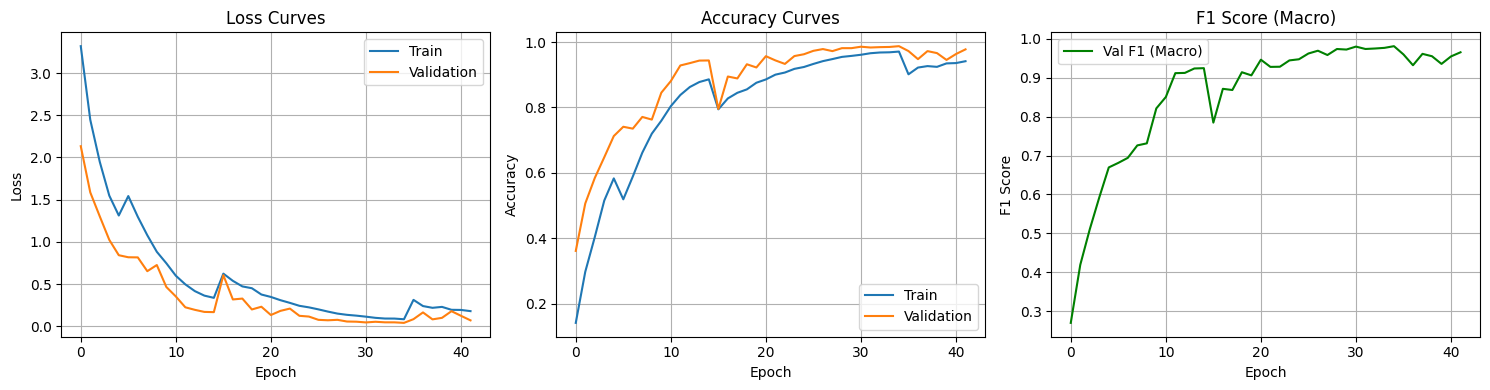

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True)

# F1 Score
axes[2].plot(history['val_f1'], label='Val F1 (Macro)', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score (Macro)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(config.CHECKPOINT_DIR / 'custom_cnn_training_curves.png', dpi=150)
plt.show()

## 7. Save Final Model

In [16]:
# Save final model
save_checkpoint(
    model, optimizer, epoch, val_metrics['accuracy'],
    config.CHECKPOINT_DIR / 'custom_cnn_final.pth',
    extra_info={
        'class_names': class_names,
        'config': {
            'num_classes': config.NUM_CLASSES,
            'dropout': config.DROPOUT,
            'variant': config.MODEL_VARIANT,
            'image_size': config.IMAGE_SIZE
        },
        'history': history
    }
)

print(f"Final model saved to: {config.CHECKPOINT_DIR / 'custom_cnn_final.pth'}")

Final model saved to: d:\Repos\plant-disease-project\models_exported\custom_cnn_final.pth


In [17]:
# Close TensorBoard logger
logger.close()

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"\nTo view TensorBoard logs, run:")
print(f"  tensorboard --logdir {config.LOG_DIR}")


TRAINING COMPLETE!
Best Validation Accuracy: 0.9876

To view TensorBoard logs, run:
  tensorboard --logdir d:\Repos\plant-disease-project\runs\custom_cnn


## 8. Quick Evaluation on Validation Set

In [18]:
# Load best model for evaluation
best_checkpoint = load_checkpoint(
    config.CHECKPOINT_DIR / 'custom_cnn_best.pth',
    model
)

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"Best validation accuracy: {best_checkpoint['best_metric']:.4f}")

Loaded best model from epoch 35
Best validation accuracy: 0.9876


In [19]:
# Final evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Final Evaluation"):
        inputs = inputs.to(config.DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate final metrics
final_metrics = metrics_calculator.calculate(
    np.array(all_labels),
    np.array(all_preds)
)

print("\nFinal Validation Metrics:")
print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  F1 (Macro): {final_metrics['f1_macro']:.4f}")
print(f"  F1 (Weighted): {final_metrics['f1_weighted']:.4f}")

Final Evaluation:   0%|          | 0/170 [00:00<?, ?it/s]


Final Validation Metrics:
  Accuracy: 0.9876
  F1 (Macro): 0.9810
  F1 (Weighted): 0.9878


In [20]:
# Display per-class F1 scores (top 10 worst performing)
import pandas as pd

f1_scores = final_metrics['f1_per_class']
class_f1_df = pd.DataFrame({
    'Class': class_names,
    'F1 Score': f1_scores
}).sort_values('F1 Score')

print("\nTop 10 Worst Performing Classes:")
print(class_f1_df.head(10).to_string(index=False))


Top 10 Worst Performing Classes:
                                             Class  F1 Score
                                  Potato___healthy  0.789474
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  0.905660
                             Tomato___Early_blight  0.944724
               Corn_(maize)___Northern_Leaf_Blight  0.947917
                              Tomato___Target_Spot  0.964539
                           Tomato___Bacterial_spot  0.969121
                              Tomato___Late_blight  0.971129
                                   Peach___healthy  0.972973
                     Pepper,_bell___Bacterial_spot  0.984925
     Tomato___Spider_mites Two-spotted_spider_mite  0.985163
